In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import quandl

In [3]:
start = pd.to_datetime('2012-01-01')

In [4]:
end = pd.to_datetime('2020-01-01')

In [5]:
appl = quandl.get('WIKI/AAPL.11',start_date=start,end_date=end)

In [6]:
cisco = quandl.get('WIKI/CSCO.11',start_date=start,end_date=end)
ibm = quandl.get('WIKI/IBM.11',start_date=start,end_date=end)
azmn = quandl.get('WIKI/AMZN.11',start_date=start,end_date=end)

In [9]:
stocks = pd.concat([appl,cisco,ibm,azmn],axis=1)
stocks.columns=['appl','cisco','ibm','azmn']

In [10]:
stocks.head()

,appl,cisco,ibm,azmn
Date,,,,
2012-01-03,52.848787,15.617341,157.578371,179.03
2012-01-04,53.132802,15.919125,156.935540,177.51
2012-01-05,53.722681,15.860445,156.191208,177.61
2012-01-06,54.284287,15.801764,154.398046,182.61
2012-01-09,54.198183,15.902359,153.594506,178.56


In [12]:
stocks.pct_change(1).mean()

appl     0.000864
cisco    0.000738
ibm      0.000045
azmn     0.001528
dtype: float64

In [13]:
stocks.pct_change(1).corr()

,appl,cisco,ibm,azmn
appl,1.000000,0.317531,0.285458,0.268870
cisco,0.317531,1.000000,0.418203,0.289248
ibm,0.285458,0.418203,1.000000,0.246818
azmn,0.268870,0.289248,0.246818,1.000000


In [14]:
log_return = np.log(stocks/stocks.shift(1))
log_return.head()

,appl,cisco,ibm,azmn
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563
2012-01-06,0.010400,-0.003707,-0.011547,0.027763
2012-01-09,-0.001587,0.006346,-0.005218,-0.022428


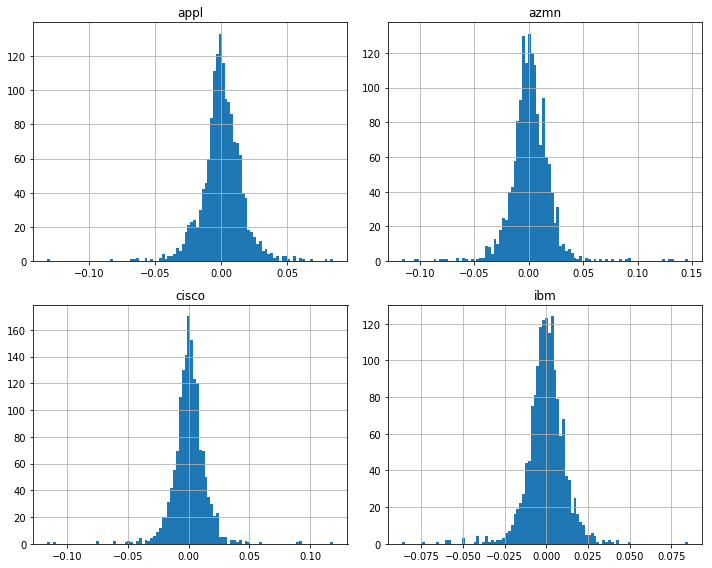

In [15]:
log_return.hist(bins=100,figsize=(10,8))
plt.tight_layout()

In [16]:
log_return.mean()

appl     0.000726
cisco    0.000642
ibm     -0.000023
azmn     0.001356
dtype: float64

In [18]:
log_return.cov() * 252

,appl,cisco,ibm,azmn
appl,0.062475,0.017422,0.013212,0.019764
cisco,0.017422,0.048174,0.017071,0.018767
ibm,0.013212,0.017071,0.034618,0.013552
azmn,0.019764,0.018767,0.013552,0.085924


In [52]:
np.random.seed(101)

num_ports = 5000
all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharp_arr = np.zeros(num_ports)
for ind in range(num_ports):
    # Weights
    weight = np.array(np.random.random(4))
    weight = weight/np.sum(weight)
    #Save weights
    all_weights[ind,:]=weight
    # Expected Return
    ret_arr[ind] = np.sum((log_return.mean()*weight)*254)
    # Expected Volatility
    vol_arr[ind] = np.sqrt(np.dot(weight.T,np.dot(log_return.cov()*252,weight)))
    # Sharpe Ratio
    sharp_arr[ind] = ret_arr[ind]/vol_arr[ind]



In [53]:
sharp_arr.max()

1.2911354828986175

In [54]:
sharp_arr.argmax()

1420

In [55]:
all_weights[1420,:]

array([0.26188068, 0.20759516, 0.00110226, 0.5294219 ])

In [57]:

max_sr_ret = ret_arr[1420]
max_sr_vol = vol_arr[1420]

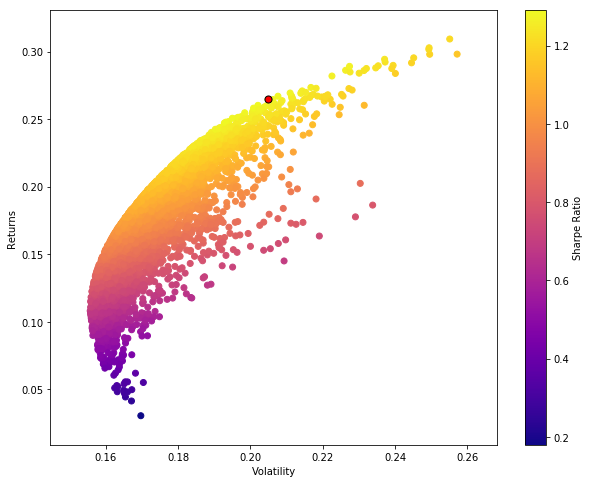

In [58]:
plt.figure(figsize=(10,8))
plt.scatter(vol_arr,ret_arr,c=sharp_arr,cmap='plasma')
plt.colorbar(label="Sharpe Ratio")
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')

In [98]:
 def get_ret_vol_sr(weights):
        weights = np.array(weights)
        ret = np.sum(log_return.mean()*weights) * 252
        vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,weights)))
        sr = ret/vol
        return np.array([ret,vol,sr])
    

In [99]:
from scipy.optimize import minimize

In [100]:
def neg_sharp(weights):
    return get_ret_vol_sr(weights)[2] * -1

In [101]:
def check_sum(weights):
    return np.sum(weights) -1

In [102]:
cons = ({'type':'eq','fun':check_sum})

In [103]:
bounds  = ((0,1),(0,1),(0,1),(0,1))

In [104]:
init_guess = [0.25,0.25,0.25,0.25]

In [105]:
opt_results = minimize(neg_sharp,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [106]:
opt_results

     fun: -1.2828472171183798
     jac: array([-0.00072451, -0.0004901 ,  0.47258657,  0.00054568])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([2.29846243e-01, 2.44943674e-01, 1.08528637e-16, 5.25210083e-01])

In [107]:
opt_results.x

array([2.29846243e-01, 2.44943674e-01, 1.08528637e-16, 5.25210083e-01])

In [108]:
get_ret_vol_sr(opt_results.x)

array([0.261193  , 0.20360413, 1.28284722])

In [121]:
frontier_y = np.linspace(0,0.35,100)

In [122]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [123]:
frontier_volatility = []
for possible_return in frontier_y:
    cons = ({'type':'eq','fun':check_sum},{'type':'eq','fun': lambda w : get_ret_vol_sr(w)[0]-possible_return})
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds, constraints=cons)
    frontier_volatility.append(result['fun'])
    

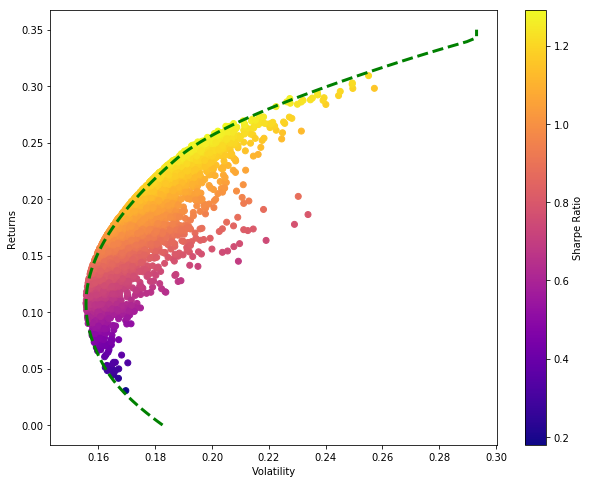

In [124]:
plt.figure(figsize=(10,8))
plt.scatter(vol_arr,ret_arr,c=sharp_arr,cmap='plasma')
plt.colorbar(label="Sharpe Ratio")
plt.xlabel('Volatility')
plt.ylabel('Returns')

plt.plot(frontier_volatility,frontier_y,'g--',linewidth = 3)